In [1]:
import os
os.chdir('../')

In [64]:
from torch.utils.data import DataLoader

from mmengine.dataset import DefaultSampler, pseudo_collate

from mmengine import Config
from mmpretrain.models import build_classifier
from mmpretrain.datasets import build_dataset
from mmpretrain.models import ClsDataPreprocessor

import matplotlib.pyplot as plt

In [91]:
cfg = Config.fromfile('projects/ma_clip/configs/vit-base-p16_pt-64xb64_in1k.py')
cfg.model.backbone.visual_proj = True
cfg.model.backbone.out_type = 'cls_token'
mm_model = build_classifier(cfg.model)
mm_model.init_weights()

05/30 11:07:37 - mmengine - INFO - load model from: data/pretrained/clip/CLIP-ViT-B-16-laion2B-s34B-b88K/pretrain.pth
05/30 11:07:37 - mmengine - INFO - Loads checkpoint by local backend from path: data/pretrained/clip/CLIP-ViT-B-16-laion2B-s34B-b88K/pretrain.pth
05/30 11:07:38 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: positional_embedding, text_projection, transformer.resblocks.0.ln_1.weight, transformer.resblocks.0.ln_1.bias, transformer.resblocks.0.attn.in_proj_weight, transformer.resblocks.0.attn.in_proj_bias, transformer.resblocks.0.attn.out_proj.weight, transformer.resblocks.0.attn.out_proj.bias, transformer.resblocks.0.ln_2.weight, transformer.resblocks.0.ln_2.bias, transformer.resblocks.0.mlp.c_fc.weight, transformer.resblocks.0.mlp.c_fc.bias, transformer.resblocks.0.mlp.c_proj.weight, transformer.resblocks.0.mlp.c_proj.bias, transformer.resblocks.1.ln_1.weight, transformer.resblocks.1.ln_1.bias, transforme

In [92]:
train_pipeline = [
    dict(
        type='LoadInstanceImage',
        with_mask=False,
        exp_factor=1.2,
        channel_order='rgb'),
    dict(type='ResizeEdge', scale=256, edge='short'),
    dict(type='RandomCrop', crop_size=224),
    dict(type='RandomFlip', prob=0.5, direction='horizontal'),
    dict(type='PackInputs'),
]

cfg.train_dataset.dataset.ann_file = 'debug/train.json'
cfg.train_dataset.pipeline = train_pipeline
dataset = build_dataset(cfg.train_dataset)

/home/ubuntu/mnt/hxm/ovd/mmdetection/mmdet/datasets/api_wrappers/coco_api.py:24: UserWarning: mmpycocotools is deprecated. Please install official pycocotools by "pip install pycocotools"
  UserWarning)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [93]:
sampler = DefaultSampler(dataset, shuffle=True)
train_loader = DataLoader(dataset=dataset, batch_size=1, sampler=sampler, collate_fn=pseudo_collate)
data_preprocessor = ClsDataPreprocessor(
    mean=[125.307, 122.961, 113.8575],
    std=[51.5865, 50.847, 51.255])

In [146]:
def load_data(train_loader):
    for data in train_loader:
        yield data
g = load_data(train_loader)

In [170]:
data = next(g)
mm_data = data_preprocessor(data, training=True)
mm_img = mm_data['inputs']

x = mm_model.backbone.encode_image(mm_img)

x[0].shape, x[0]

(torch.Size([1, 512]),
 tensor([[ 9.8663e-01, -4.1028e-01, -1.1107e+00,  7.6798e-01, -1.4718e-01,
          -4.6158e-01,  7.8164e-01,  6.6800e-01,  1.3709e+00, -6.9034e-02,
          -4.2050e-01, -3.5070e-02,  1.4871e-01,  7.5958e-02,  2.2483e-01,
          -6.4970e-01,  3.2864e-01,  2.5999e-01,  5.6622e-01,  1.5882e-01,
          -6.0482e-02, -1.2209e-01,  6.9032e-01,  5.5445e-01, -2.9007e-01,
          -1.1045e-01, -1.1747e+00,  1.7055e-01,  1.3401e-01,  2.2619e-01,
           1.6549e-01,  4.2295e-01, -1.8405e-01, -1.9627e-01,  1.8611e-02,
           1.0488e-01, -1.1208e-03,  4.6936e-01, -1.9912e-01, -1.4406e-01,
          -1.0410e-01,  1.7351e-01, -7.7132e-02,  7.9531e-02,  3.8199e-01,
           8.8837e-02, -1.4090e+00,  1.0484e-01, -3.3092e-01, -3.1771e-01,
           5.9442e-01, -3.7409e-01,  3.5062e-02, -8.7610e-03, -1.7662e-02,
           5.1124e-01, -1.9772e-01,  4.8564e-01, -3.5512e-01,  4.5736e-01,
          -1.2395e-02, -5.1245e-01,  4.8340e-01, -2.2864e-02, -4.0269e-01,
  

In [171]:
ori_img = data['inputs'][0]

In [85]:
import open_clip
import torch

In [155]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='laion2b_s34b_b88k')



In [172]:
with torch.no_grad():
    image_features = model.encode_image(mm_img)

(x[0] - image_features).abs().max()

tensor(0.0022, grad_fn=<MaxBackward1>)

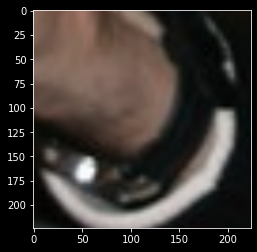

In [173]:
plt.imshow(ori_img.permute(1, 2, 0).numpy())

In [76]:
ori_img

tensor([[[ 57,  54,  52,  ..., 194, 198, 199],
         [ 58,  54,  50,  ..., 195, 198, 198],
         [ 59,  53,  48,  ..., 196, 198, 198],
         ...,
         [  0,   1,   1,  ..., 185, 213, 236],
         [  0,   0,   0,  ..., 196, 220, 240],
         [  3,   3,   3,  ..., 206, 226, 240]],

        [[ 61,  58,  56,  ..., 179, 184, 185],
         [ 62,  58,  54,  ..., 181, 184, 185],
         [ 63,  58,  52,  ..., 182, 184, 184],
         ...,
         [  1,   2,   3,  ..., 173, 202, 224],
         [  0,   1,   2,  ..., 185, 210, 229],
         [  4,   4,   4,  ..., 196, 217, 231]],

        [[ 67,  65,  62,  ..., 171, 174, 175],
         [ 67,  63,  59,  ..., 172, 174, 174],
         [ 66,  61,  55,  ..., 174, 174, 173],
         ...,
         [  3,   3,   2,  ..., 162, 190, 213],
         [  3,   2,   1,  ..., 175, 200, 219],
         [  6,   5,   4,  ..., 187, 207, 221]]], dtype=torch.uint8)